##### CSCI 303
# Introduction to Data Science
<p/>
### 14 - Classification

![knn classification](knn_class.png) 

## This Lecture
---
- Classification concepts
- *k*-Nearest Neighbor Classification

## Setup
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

from scipy.stats import norm
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

plt.style.use('ggplot')

%matplotlib inline

## Recall: Machine (or Statistical) Learning
---
- Learning structure and relationships in data
- Supervised learning
  - Goal is predicting outputs based on inputs
  - Learn from labeled exemplar data
  - E.g., regression, classification
- Unsupervised learning
  - Goal is reveal hidden structure in the data
  - Inputs but no labeled outputs
  - E.g., clustering

## Regression
---
...we've seen.  We'll return to regression in a later lecture to talk about other techniques.


## Classification
---
In classification, we try to predict a *class label* assigning points to groups.

Our classification training data has the same kinds of inputs as in regression, but the *target* variable is discrete, not continuous.

E.g., the training data might include features about a borrower's financial history, credit score, owning/renting history, etc.  The target might be an indicator on whether or not the borrower ultimately defaulted on their loan.

The learning task is to find a *classifier* function which will let us predict future defaults given the same information about a potential borrower.


## Example Problem
---
As with regression, we'll start with an artificially generated problem.  Inputs will be points in a 2-D space, and targets will be classes simply labeled as 'a' and 'b'.

In [2]:
# ensure repeatability of this notebook 
# (comment out for new results each run)
np.random.seed(0)

def f(X):
    return 3 + 0.5 * X - X**2 + 0.15 * X**3

# convenience function for generating samples
def sample(n, fn, limits, sigma):
    width = limits[1] - limits[0]
    height = limits[3] - limits[2]
    x = np.random.random(n) * width + limits[0]
    y = np.random.random(n) * height + limits[2]
    s = y > fn(x)
    p = norm.cdf(np.abs(y - fn(x)), scale = sigma)
    r = np.random.random(n)
    
    def assign(sign, prob, rnum):
        if sign:
            if rnum > prob:
                return 'b'
            else:
                return 'a'
        else:
            if rnum > prob:
                return 'a'
            else:
                return 'b'
        
    c = [assign(s[i], p[i], r[i]) for i in range(n)]
    return DataFrame({'x' : x, 'y' : y, 'class' : c})
    

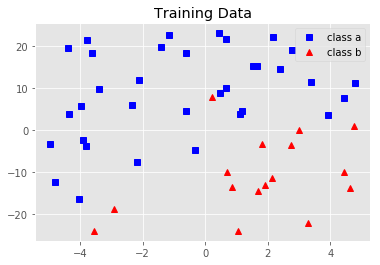

In [3]:
data = sample(100, f, [-5, 5, -25, 25], 5)
train, test = train_test_split(data, test_size = 0.5)
traina = train[train['class']=='a']
trainb = train[train['class']=='b']
plt.plot(traina['x'], traina['y'],'bs', label='class a')
plt.plot(trainb['x'], trainb['y'],'r^', label='class b')
plt.legend()
plt.title('Training Data')
plt.show()

## *k*-Nearest Neighbor Classification
---
Suppose we get a new point we haven't seen before, class unknown.

What class do we assign it to?

One of the simplest techniques is *k-nearest neighbor* classification.

Simply look at the *k* nearest points and take a majority vote on the class!

Let's try k-nearest neighbor on our example, using scikit-learn:

In [4]:
from sklearn import neighbors

k = 5

model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Plotting the results is a bit tricky.  Here are a few approaches.

First, we can apply the trained model to the test data, and plot the resulting points.  Correctly classified points will be shown as solid, misclassified points as bordered.  Colors and shapes will match the prediction (not the ground truth).

In [5]:
def plot_predicted_1(model, test):
    predicted = model.predict(test[['x','y']])
    correct = test[test['class'] == predicted]
    correcta = correct[correct['class'] == 'a']
    correctb = correct[correct['class'] == 'b']
    incorrect = test[test['class'] != predicted]
    incorrecta = incorrect[incorrect['class'] == 'b']
    incorrectb = incorrect[incorrect['class'] == 'a']
    
    plt.plot(correcta['x'], correcta['y'], 'bs', label='a')
    plt.plot(correctb['x'], correctb['y'], 'r^', label='b')
    plt.plot(incorrecta['x'], incorrecta['y'], 'bs', markerfacecolor='w', label='a (misclassified)')
    plt.plot(incorrectb['x'], incorrectb['y'], 'r^', markerfacecolor='w', label='b (misclassified)')
    plt.legend(loc='upper left', ncol=2, framealpha=1)

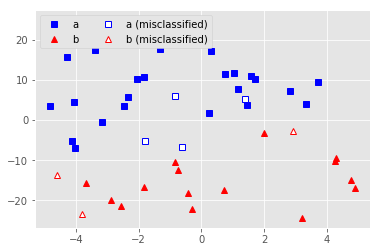

In [6]:
plot_predicted_1(model, test)

One problem with this plot is that it doesn't show us the original training data, so it can be difficult to see where the misclassifications came from.

Another plot, harder to generate, shows us the "decision boundary" - the dividing line between classes.

In [7]:
def plot_predicted_2(model, test):
    #setup colormap using hex values for blue and red
    cmap = ListedColormap(['#8888FF','#FF8888'])
    
    #set up for the axis ranges we want x values and y values
    xmin, xmax, ymin, ymax = -5, 5, -25, 25
    
    #set up the grid for the contour ... create a rectangular grid out of an array of our x and y values. 
    #To create a rectangular grid, we need every combination of the x and y points using the grid_size.
    grid_size = 0.1
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grid_size), 
                         np.arange(ymin, ymax, grid_size))
    
    #now find y_hat using the prediction function, ravel returns a flattened 1D array of the data in xx and yy
    pp = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    #filling an arry for the plot function, this comprehension goes through the elements returned from the prediction
    #filled with predicted a or be class labels; the first part is replacing all the a's with a 0 and the b's with 1
    zz = np.array([{'a':0,'b':1}[ab] for ab in pp]) 

    #the reshape puts the zz array in the same shape as the xx aray, again so we can plot like shaped objects
    zz = zz.reshape(xx.shape)
    
    #create a new figture, and plot it using the x, y - zz is the class labesl a=0, b=1 and the cmap is the blue or red
    plt.figure()
    plt.pcolormesh(xx, yy, zz, cmap = cmap)
    
    #this calls our other function as an overlay with the actual data points - comment it out and run it to see
    plot_predicted_1(model, test)


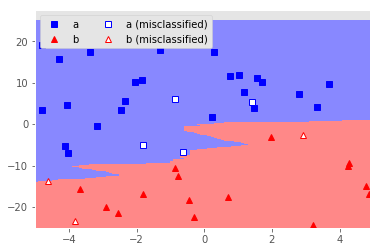

In [8]:
plot_predicted_2(model, test)
plt.show()

Using the functions we wrote above, we can also plot all of the data, or just the training data:

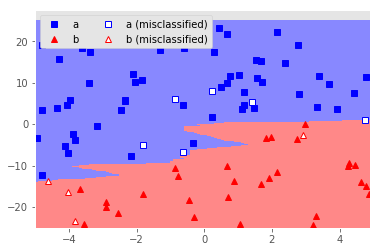

In [9]:
plot_predicted_2(model, data)
plt.show()

## Model Complexity with *k*-Nearest Neighbors
---
Above we used k = 5 to train our model.  As we saw, this gave a fairly smooth decision boundary.

What happens if we decrease or increase *k*?

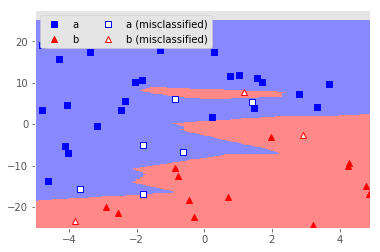

In [10]:
k = 1
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, test)
plt.show()

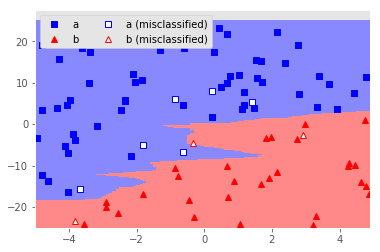

In [11]:
k = 3
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

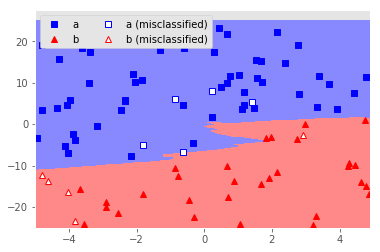

In [12]:
k = 7
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

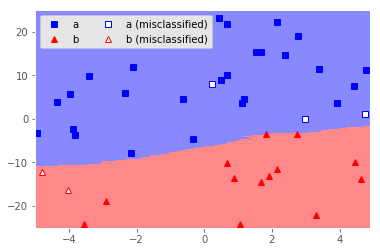

In [13]:
k = 9
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, train)
plt.show()

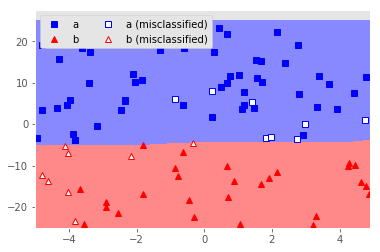

In [14]:
k = 15
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

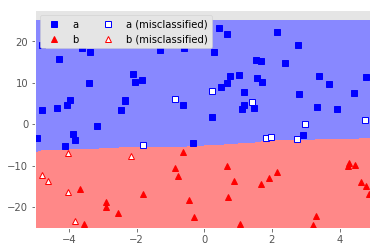

In [15]:
k = 21
model = neighbors.KNeighborsClassifier(k)
model.fit(train[['x','y']], train['class'])
plot_predicted_2(model, data)
plt.show()

## Overfitting/Underfitting
---
Just like with regression, classification is sensitive to the complexity of your model.

In *k*-nearest neighbor classification, you overfit by using too few neighbors, and underfit by using too many neighbors.

The scikit-learn nearest neighbor model can generate a score based on the accuracy of our prediction.  Let's see our training and test curves:

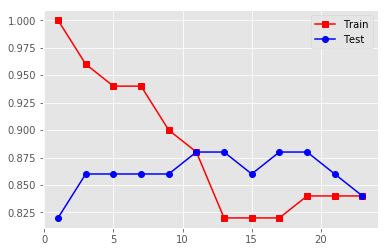

In [16]:
kvals = range(1,25,2)
train_score = []
test_score = []

for k in kvals:
    model = neighbors.KNeighborsClassifier(k)
    model.fit(train[['x','y']], train['class'])
    train_score.append(model.score(train[['x','y']], train['class']))
    test_score.append(model.score(test[['x','y']], test['class']))
    
plt.plot(kvals, train_score, 'r-s', label='Train')
plt.plot(kvals, test_score, 'b-o', label='Test')
plt.legend()
plt.show()

In [17]:
print(sk.metrics.confusion_matrix(test['class'], model.predict(test[['x','y']])))
model.score(test[['x','y']], test['class'])


[[28  3]
 [ 5 14]]


0.83999999999999997

## Next Time
---
More classification goodness!